In [1]:
%matplotlib inline
import sys
import numpy as np
#from numpy import linalg as LA
import matplotlib.pyplot as plt
#sys.path.append("./b1_hl_likelihood")
import bicep1_util as b1u

# Overview


The code blocks in this notebook do the following:
* load the BICEP1 Hamimeche & Lewis likelihood code
* walk through the likelihood evaluation for a given theoretical model

The BICEP1 data and analysis are described by Barkats <i>et al.</i> (2014), https://arxiv.org/abs/1310.1422  
The Hamimeche & Lewis likelihood approach is described by Hamimeche & Lewis (2008), https://arxiv.org/abs/0801.0554

This notebook was prepared on behalf of NASA's Legacy Archive for Microwave Background Data Analysis (LAMBDA, https://lambda.gsfc.nasa.gov/). If you have any comments or questions contact Graeme Addison at gaddison@jhu.edu.

In [2]:
# the following code is taken from the b1_r_wrapper.py script
# the exp (experiment) and field (type of spectra) are set to BICEP1 and B (for B-mode)
# rlist contains the array of values of tensor-to-scalar ratio r that are evaluated by the likelihood
exp = 'bicep1'
field = 'B'
rlist = np.arange(-1.2, 5.01, 0.01) # default r values to evaluate for B1

## Reading in power spectra and noise arrays, covariance and bandpower window functions

Explanation of arrays returned in the code block below:

<b>C_l</b> is the theory power spectrum. For now, this is just an array of zeros.

<b>C_l_hat</b> is the power spectrum bandpowers measured from the BICEP data

<b>N_l</b> is the noise contribution to the power spectrum bandpowers, estimated from noise-only simulations

<b>C_fl</b> is the fiducial power spectrum bandpowers, estimated from signal+noise simulations

<b>M_inv</b> is the inverse covariance matrix; there are nine bandpowers so this is a $9\times9$ matrix

The BICEP bandpowers are defined as:

$$\left\langle\mathcal{D}_b^{XY}\right\rangle=\sum_{\ell}w_{b,\ell}^{XY}\mathcal{D}_{\ell}^{XY}$$

That is, each bandpower $b$ is a linear combination of the spectra measured at each multipole $\ell$, with a weighting function $w_{b,\ell}$.

<b>bpwf_l</b> and <b>bpwf_Cs_l</b> are the $\ell$ and $w_{b,\ell}$ arrays. These arrays are used to convert theory power spectra at each $\ell$ to theory bandpowers that can be directly compared with the data.

In [3]:
C_l, C_l_hat, N_l, C_fl, M_inv, bpwf_l, bpwf_Cs_l =  b1u.init(exp, field)

### Reading the BICEP1 BPWF from  file: windows/B1_3yr_bpwf_bin?_20131003.txt
### Reading fiducial, real, and noise bias bandpowers from file: B1_3yr_likelihood_bandpowers_20131003.txt
### Reading covariance matrix (M_cc) from file: B1_3yr_bpcm_20131003.txt


## Reading in the input theory spectra

The three cells below read in the theory power spectra and convert the power at each $\ell$ into bandpowers as described above.

The first block is the primordial B-mode power for $r=0.1$. The likelihood for different values of $r$ is then obtained by rescaling this quantity by $r/0.1$.

The second block is the lensing B-mode power (generated from lensing of E-mode signal).

The third block is the B-mode power expected aside from the primordial B-modes and lensing. This is set to zero in the BICEP analysis although in principle some other contribution could be added here.

In [4]:
# Load the input r = 0.1 BB spectrum
file_in = "./b1_hl_likelihood/camb_wmap5yr_withB_uK.txt"
(ell, BB_Cs_l) = b1u.load_cmbfast(file_in)

### Loading input spectra from file: ./camb_wmap5yr_withB_uK.txt


In [5]:
# Load the LCDM + lensing spectra
lensing = "./b1_hl_likelihood/camb_wmap5yr_lensed_uK.txt"
(ell1, inpmodLensing_Cs_l) = b1u.load_cmbfast(lensing)
expvLensing = b1u.calc_expvals(ell1, inpmodLensing_Cs_l, bpwf_l, bpwf_Cs_l)

### Loading input spectra from file: ./camb_wmap5yr_lensed_uK.txt


In [6]:
# Load the LCDM input spectra
LCDM = "./b1_hl_likelihood/camb_wmap5yr_noB_uK.txt"
(ell1, inpmodLCDM_Cs_l) = b1u.load_cmbfast(LCDM)
expvLCDM = b1u.calc_expvals(ell1, inpmodLCDM_Cs_l, bpwf_l, bpwf_Cs_l)

### Loading input spectra from file: ./camb_wmap5yr_noB_uK.txt


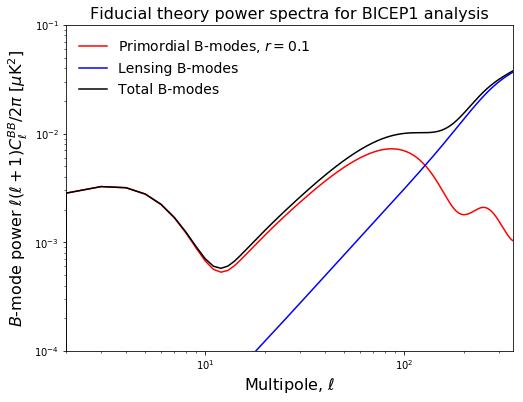

In [7]:
# plot showing the primordial and lensing B-modes for the fiducial model used in the BICEP analysis

fig = plt.figure(figsize=(8,6))
plt.plot(ell, BB_Cs_l[:,3], 'r', label=r'Primordial B-modes, $r=0.1$')
plt.plot(ell1, inpmodLensing_Cs_l[:,3], 'b', label=r'Lensing B-modes')
plt.plot(ell1, BB_Cs_l[:,3] + inpmodLensing_Cs_l[:,3], 'k', label=r'Total B-modes')
plt.xlim([2, 350])
#plt.ylim([-0.002, 0.02])
plt.xscale('log')
plt.ylim([1e-4, 1e-1])
plt.yscale('log')
plt.xlabel(r"Multipole, $\ell$", size=16)
plt.ylabel(r"$B$-mode power $\ell(\ell+1)C_{\ell}^{BB}/2\pi$ [$\mu$K$^2$]", size=16)
plt.legend(loc=2, frameon=False, fontsize=14)
plt.title('Fiducial theory power spectra for BICEP1 analysis', size=16)
plt.show()

## Evaluating the likelihood

We're now ready to evaluate the likelihood. We start by specifying a value of $r$, and computing the total theory B-mode bandpower predictions (primordial B-modes plus the lensing). The expected noise bias is also included.

In [8]:
# evaluate likelihood for single value of r

r = 0.2

expv = expvLCDM.copy()

# Scale the BB spectrum from fiducial model (r=0.1) and perform bandpower binning
this_mod = BB_Cs_l.copy()
this_mod[:,3] = np.multiply(this_mod[:,3], r/0.1)
expvBB = b1u.calc_expvals(ell, this_mod, bpwf_l, bpwf_Cs_l)

# Add the scaled BB + the fixed lensing BB (plus any additional ex)
expv[:,3] = expv[:,3] + expvBB[:,3] + expvLensing[:,3]

C_l[:,0,0] = expv[:,3] 

# add Noise bias N_l to expectation values.
C_l = C_l + N_l

The description below is taken from Section 9 of Barkats <i>et al.</i> (2014). More mathematical details can be found in Section II. E of Hamimeche & Lewis (2008), where it is shown that, while the likelihood approximation is only exact on the full sky, it remains good enough on cut-sky analyses like BICEP at $\ell>30$.

The likelihood approximation is

$$-2\log\mathcal{L}(\mathcal{D}_b\mid\hat{\mathcal{D}}_b)=X_c\mathcal{M}_{cc'}^{-1}X_{c'},$$

where $\mathcal{D}_b$ are the model bandpowers and $\hat{\mathcal{D}}_b$ are the data. The indices $c$ and $c'$ run over combinations of $\ell$-bins and six spectra ($TT$, $EE$, $BB$, $TE$, $EB$, and $TB$), while $b$ runs over $\ell$-bins only.

This is a quadratic likelihood that looks similar to a $\chi^2$, however the vector $X_c$ here is not the vector of bandpowers themselves but rather a transformed version of the bandpowers, where the transformation is designed to correct the shape of the likelihood (Section II. E. of Hamimeche & Lewis, 2008):

$$\left(X_b^{TT}, X_b^{EE}, X_b^{BB}, X_b^{TE}, X_b^{EB}, X_b^{TB}\right)=\textrm{vecp}\left((\mathcal{D}_b^f)^{1/2}{\bf U}_b\,g({\bf D}_b){\bf U}_b^{\dagger}(\mathcal{D}_b^f)^{1/2}\right)$$

In this expression, $\mathcal{D}_b^f$ are fiducial bandpowers from the mean of $\Lambda$CDM signal-plus-noise simulations (the same simulations used to calculate the bandpower covariance $\mathcal{M}_{cc'}$. Matrices ${\bf U}_b$ and ${\bf D}_b$ are the eigenvectors and eigenvalues of the matrix product ${\bf\mathcal{D}}^{-1/2}_b{\bf\hat{\mathcal{D}}}_b{\bf\mathcal{D}}^{-1/2}_b$, and the function

$$g(x)\equiv{\rm sign}(x-1)\sqrt{2(x-\ln x-1)}$$

acts on the diagonal matrix ${\bf D}_b$ to form $g({\bf D}_b)$.

In [9]:
# calling the function to evaluate the likelihood approximation for a given set of C_l, C_l_hat, C_fl, and M_inv
logL = b1u.evaluateLikelihood(C_l, C_l_hat, C_fl, M_inv)
logLike = np.real(logL)
print logLike    

-3.05856815253


We can also compute the likelihood for a range of $r$ values, recalculating the expected fiducial spectrum each time, and make a plot similar to Figure 10 from Barkats <i>et al.</i> Since the uncertainty in $r$ is large the plot extends to (unphysical) negative values of $r$ rather than truncating at zero, in order to give a better sense for the width of the distribution.

In [10]:
# Initiating the logarithmic likelihood arrays
logLike = np.zeros(len(rlist))

# loop over r values
for i in range(len(rlist)):
    expv = expvLCDM.copy()
    
    r  =  rlist[i]
    # Scale the BB spectrum from fiducial model (r=0.1) and get its expectation value
    this_mod = BB_Cs_l.copy()
    this_mod[:,3] = np.multiply(this_mod[:,3], r/0.1)
    expvBB = b1u.calc_expvals(ell, this_mod, bpwf_l, bpwf_Cs_l)

    # Add the scaled BB + the fixed lensing BB to the LCDM
    expv[:,3] = expv[:,3] + expvBB[:,3] + expvLensing[:,3]
    
    C_l[:,0,0] = expv[:,3] 
    
    # add Noise bias N_l to expectation values.
    C_l = C_l + N_l

    logL = b1u.evaluateLikelihood(C_l, C_l_hat, C_fl, M_inv)
    logLike[i] = np.real(logL)

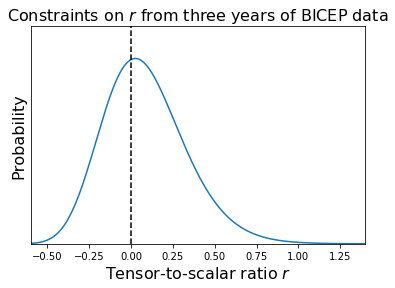

In [11]:
plt.plot(rlist, np.exp(logLike))
plt.axvline(0., c='k', ls='--')
plt.xlim([-0.6, 1.4])
plt.ylim([0, 0.07])
plt.yticks([])
plt.xlabel(r'Tensor-to-scalar ratio $r$', size=16)
plt.ylabel(r'Probability', size=16)
plt.title(r'Constraints on $r$ from three years of BICEP data', size=16)
plt.show()